In [5]:
# import os
# os.environ['TRITON_INTERPRET'] = '1' # needs to be set *before* triton is imported

import torch
import triton
import torch.nn.functional as F
import sys
sys.path.append('/home/roark/Documents/7_cuda/triton/rk/rk_triton')
sys.path.append('/home/roark/Documents/7_cuda/triton')
from functions.SDPA import ScaledDotProductAttention
from triton_tutorials.fused_attention import attention4090
from triton_tutorials.attention import attention

DEVICE = triton.runtime.driver.active.get_active_torch_device()
sdpa = ScaledDotProductAttention.apply

## Benchmark

### Triton tool benchmark

#### forward

In [6]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [7]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['T'],
        x_vals=[2 ** i for i in range(9, 14)],
        line_arg='provider',
        line_vals=['triton', 'torch'], #, 'triton_tutorial'],
        line_names=['Triton', 'Torch'], #, 'Tutorial'],
        styles=[('blue', '-'), ('green', '-')], #, ('orange', '-')],
        ylabel='Tflops',
        plot_name='att-forward',
        args={'B':4, 'H':4, 'd': 128,'causal': True,  'dtype': torch.bfloat16, 'mode': 'forward'},
    ))
def bench_att(B, H, T, d, causal, dtype, provider, mode, device=DEVICE):
    # create data
    q, k, v = torch.rand((3, B*H, T, d), requires_grad=True, device=device, dtype=dtype)
    q_torch, k_torch, v_torch = torch.rand((3, B, H, T, d), requires_grad=True, device=device, dtype=dtype)

    def y_fwd():
        if provider == "torch":
            # Careful: do not use input with (B*H, T, d) shape here, hurt performance a lot!
            return F.scaled_dot_product_attention(q_torch, k_torch, v_torch, is_causal=causal) 
        if provider == "triton":
            return sdpa(q, k, v, causal)
        
    flops_per_mm = B * H * T * T * d * 2
    fwd_flops_mm = 2 * flops_per_mm
    if causal:
        fwd_flops_mm *= 0.5
    # forward pass
    if mode == 'forward':
        ms = triton.testing.do_bench(y_fwd)
        total_flops = fwd_flops_mm
    tflops = lambda ms: total_flops * 1e-12 / (ms * 1e-3)
    return tflops(ms)

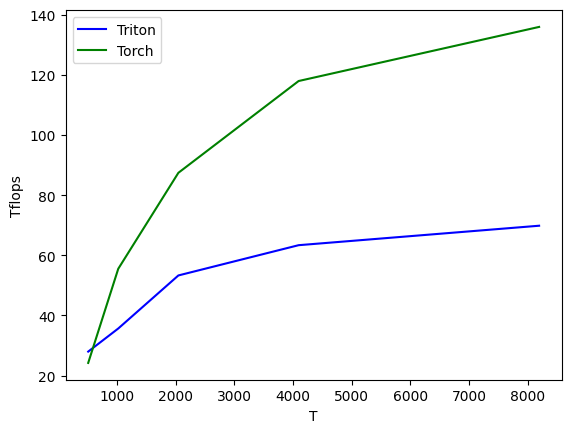

att-forward:
        T     Triton       Torch
0   512.0  27.986721   24.226634
1  1024.0  35.666891   55.514964
2  2048.0  53.295138   87.403639
3  4096.0  63.350084  117.903327
4  8192.0  69.818679  135.881666


In [8]:
bench_att.run(print_data=True, show_plots=True)

#### backward

In [14]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['T'],
        x_vals=[2 ** i for i in range(9, 14)],
        line_arg='provider',
        line_vals=['triton', 'torch'], #, 'triton_tutorial'],
        line_names=['Triton', 'Torch'], #, 'Tutorial'],
        styles=[('blue', '-'), ('green', '-')], #, ('orange', '-')],
        ylabel='Gflops',
        plot_name='att-backward',
        args={'B':4, 'H':4, 'd': 128,'causal': True,  'dtype': torch.bfloat16, 'mode': 'backward'},
    ))
def bench_att(B, H, T, d, causal, dtype, provider, mode, device=DEVICE):
    # create data
    shape = (B, H, T, d) # this shape hurt performance of F.scaled_dot_product_attention
    q = torch.rand(shape, requires_grad=True, device=device, dtype=dtype)
    k = torch.rand(shape, requires_grad=True, device=device, dtype=dtype)
    v = torch.rand(shape, requires_grad=True, device=device, dtype=dtype) 
    do = torch.ones(shape, device=device, dtype=dtype)

    def y_fwd():
        # if provider == "triton_tutorial":
        #     return attention(q, k, v, causal, 1.0) 
        if provider == "torch":
            return F.scaled_dot_product_attention(q, k, v, is_causal=causal) 
        if provider == "triton":
            return sdpa(q.view(B*H, T, d), k.view(B*H, T, d), v.view(B*H, T, d), causal)
        
    flops_per_mm = B * H * T * T * d * 2
    fwd_flops_mm = 2 * flops_per_mm
    if causal:
        fwd_flops_mm *= 0.5
    bwd_flops_mm = 2.5 * fwd_flops_mm
    # forward pass
    if mode == 'forward':
        ms = triton.testing.do_bench(y_fwd)
        total_flops = fwd_flops_mm
    # backward pass
    if mode == 'backward':
        if provider == "torch":
            ms = triton.testing.do_bench(lambda: y_fwd().backward(do))
        if provider == "triton":
            ms = triton.testing.do_bench(lambda: y_fwd().backward(do.view(B*H, T, d)))
        total_flops = bwd_flops_mm
    gflops = lambda ms: total_flops * 1e-9 / (ms * 1e-3)
    return gflops(ms)

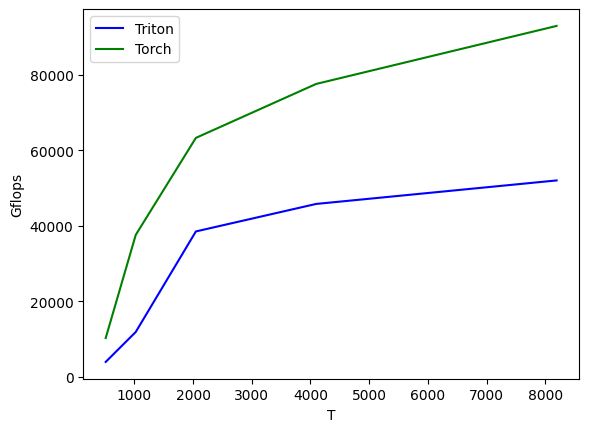

att-backward:
        T        Triton         Torch
0   512.0   3976.680117  10291.855309
1  1024.0  11904.744269  37608.187939
2  2048.0  38513.530335  63274.492440
3  4096.0  45791.427712  77549.415620
4  8192.0  52011.702216  92907.783432


In [15]:
bench_att.run(print_data=True, show_plots=True)

### Just timing

In [ ]:
B, H, T, d = 2, 4, 512, 128
device = DEVICE
dtype = torch.float16
shape = (B, H, T, d)
q = torch.rand(shape, requires_grad=True, device=device, dtype=dtype)
k = torch.rand(shape, requires_grad=True, device=device, dtype=dtype)
v = torch.rand(shape, requires_grad=True, device=device, dtype=dtype)
do = torch.ones(shape, device=device, dtype=dtype)

In [ ]:
import numpy as np
import time

def time_fwd_function(func, inputs, warm_up=5, num_trials=10):
    for _ in range(warm_up):
        with torch.no_grad():
            func(*inputs)
    if_cuda_then_sync() # Important!

    times = []
    for _ in range(num_trials):
        start_time = time.time()
        with torch.no_grad():
            func(*inputs)
        end_time = time.time()
        if_cuda_then_sync()
        times.append((end_time - start_time) * 1000) # convert s to ms
    
    return np.mean(times), np.std(times)

In [ ]:
def time_cuda(func, inputs, do, warm_up=2, num_trials=5):
    for _ in range(warm_up):
        o = func(*inputs)
        o.backward(do)
        for i in inputs:
            if torch.is_tensor(i):
                i.grad.zero_()
    if torch.cuda.is_available(): torch.cuda.synchronize()

    times_fwd, times_bwd = [], []
    for _ in range(num_trials):
        start_event = torch.cuda.Event(enable_timing=True)
        fwd_event = torch.cuda.Event(enable_timing=True)
        bwd_event = torch.cuda.Event(enable_timing=True)
        
        start_event.record()
        o = func(*inputs)
        fwd_event.record()

        o.backward(do)
        bwd_event.record()
        
        # ensures the GPU has finished works before we ask for the elapsed time.
        torch.cuda.synchronize()

        for i in inputs:
            if torch.is_tensor(i):
                i.grad.zero_()

        times_fwd.append(start_event.elapsed_time(fwd_event))  # already in ms
        times_bwd.append(fwd_event.elapsed_time(bwd_event))    # already in ms
    
    fwd_mean, fwd_std = np.mean(times_fwd), np.std(times_fwd)
    bwd_mean, bwd_std = np.mean(times_bwd), np.std(times_bwd)
    print(f'forward mean: {fwd_mean:.2f}ms, backward mean: {bwd_mean:.2f}ms')
    # return fwd_mean, fwd_std, bwd_mean, bwd_std

In [ ]:
# test
o = attention4090(q, k, v, True, 1.0)
rk_o = sdpa(q, k, v, True, 1.0)
torch_o = torch_sdpa(q, k, v, True, 1.0)
print(torch.max(torch.abs(o-torch_o)))
print(torch.max(torch.abs(rk_o - torch_o)))

CompilationError: at 87:24:
            o_i, l_i, m_i, q_i, 
            k_block_ptr_base, v_block_ptr_base, 
            qk_scale, idx_row, T,
            stage=0, # flag for not causal
            BF16=BF16,
            dtype=dtype,
            Br=Br, Bc=Bc, BLOCK_SIZE_D=BLOCK_SIZE_D,  
        )
    else: 
        # processing the tiles below diag first then tiles on diag
        # Pass the base pointers (offset 0) to both stages. _att_fwd_inner calculates the correct offset.
        o_i, l_i, m_i = _att_fwd_inner(
                        ^

In [ ]:
time_cuda(attention, (q, k, v, True, 1.0), do)

forward mean: 536.17ms, backward mean: 2801.39ms


(np.float64(536.1749172210693),
 np.float64(9.292810292448682),
 np.float64(2801.394557952881),
 np.float64(19.95279246004318))

In [ ]:
time_cuda(attention4090, (q, k, v, True, 1.0), do)

forward mean: 521.29ms, backward mean: 2836.95ms


(np.float64(521.2877563476562),
 np.float64(6.616366958929409),
 np.float64(2836.953662109375),
 np.float64(45.5220839976362))

In [ ]:
time_cuda(sdpa, (q, k, v, True, 1.0), do)

InterpreterError: AssertionError('Both operands must be same dtype. Got fp32 and fp16')

In [ ]:
def naive_sdpa(q, k, v, causal, scale):
    B, H, T, d = q.shape
    attn_bias = torch.zeros(T, T, dtype=q.dtype, device=q.device)

    qkt = q @ k.transpose(-2, -1) * scale
    if causal:
        temp_mask = torch.ones(T, T, dtype=torch.bool, device=q.device).tril(diagonal=0)
        attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
    qkt += attn_bias
    score = torch.softmax(qkt, dim=-1)
    alpha = score @ v
    return alpha

In [ ]:
# compiled_naive_sdpa = torch.compile(naive_sdpa) # 有问题，跑很长时间都不出结果

In [ ]:
naive_o = naive_sdpa(q, k, v, True, 1.0)
print(torch.max(torch.abs(naive_o-torch_o)))

tensor(0.0054, device='cuda:0', dtype=torch.float16)


In [ ]:
time_cuda(torch_sdpa, (q, k, v, True, 1.0), do)
time_cuda(naive_sdpa, (q, k, v, True, 1.0), do)

forward mean: 0.17ms, backward mean: 0.50ms


(np.float64(0.1747608184814453),
 np.float64(0.00976410682619497),
 np.float64(0.5013942718505859),
 np.float64(0.006947764481946561))